In [1]:
%matplotlib inline

In [2]:
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import FIG_DIR, DATA_DIR


In [3]:
figure_data_file = os.path.join(FIG_DIR, 'fig_5_data.csv')

if not os.path.exists(figure_data_file):
    df = pd.read_csv(os.path.join(DATA_DIR, 'MFP.csv'))

    # for each of user, get list of food consumed before the meal 
    meals = ['breakfast', 'lunch', 'dinner', 'snack']
    all_dic = defaultdict(dict)
    for meal in meals:
        df1 = df[df['meal'] == meal]
        all_dic[meal] = df1.groupby(['uid', 'days'])['food_id'].apply(list).to_dict()

    def user_repeated_cnt_time_bounded(dic_prev, dic_curr):
        window_size = 7
        repeated_cnt = defaultdict(int)
        for user, t in sorted(dic_curr.keys()):
            curr_food = set(dic_curr[(user, t)])
            results_list = [dic_prev.get((user, n), [])
                            for n in np.arange(t - (window_size - 1), t, 1)]
            prev_food = set().union(*results_list)
            if len(prev_food) != 0:
                repeated_cnt[user] += len(curr_food & prev_food)
        return repeated_cnt

    user_repeated_cnt = defaultdict(dict)
    for pair in product(meals, repeat=2):
        prev, curr = pair
        user_repeated_cnt[pair] = user_repeated_cnt_time_bounded(all_dic[prev], all_dic[curr])

    # Or for each user-meal, %repeat consumption = 1- unique/total
    df4 = df.groupby(['uid', 'meal'])['food_id'].apply(list).reset_index()
    df4['n_consumption'] = df4['food_id'].apply(len)
    for prev_meal in meals:
        df4['prev_' + prev_meal] = df4.apply(lambda s: user_repeated_cnt[
            (prev_meal, s['meal'])].get(s['uid'], np.nan),
                                             axis=1)
        df4['p_' + prev_meal] = df4['prev_' + prev_meal] / df4['n_consumption']

    data = df4.melt(id_vars=['uid', 'meal'], value_vars=['p_breakfast', 'p_lunch', 'p_dinner', 'p_snack'])

    # ignore all na
    corr = data.dropna().groupby(['variable', 'meal'])['value'].mean().unstack()
    corr = corr.rename_axis('Preceding').rename_axis('Current', axis='columns')
    corr.to_csv(figure_data_file, index=True)


In [4]:
ticks = ['Breakfast', 'Lunch', 'Dinner', 'Snack']


def plot_fig5(data, context='poster', cmap='PuBu'):
    # set background param
    if context == 'paper':
        plt.rc('pdf', fonttype=42)
        sns.set(style="ticks")
        sns.set_context(context, font_scale=1.5)
        figsize = (5, 4.5)
        vmax, vmin = .4, 0
        cmap = "YlGnBu"
        adjust = 0.41
    else:
        plt.rc('pdf')
        sns.set(style="whitegrid")
        sns.set_context(context, font_scale=0.8)
        figsize = (12, 6)
        vmax, vmin = .4, 0
        adjust = 0.41

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(data, xticklabels=ticks, yticklabels=ticks, vmax=vmax, vmin=vmin,
                     square=True, cmap=cmap, linewidths=0.5, cbar=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    if adjust:
        fig.subplots_adjust(bottom=adjust, left=adjust, )

    # save figure
    fig.tight_layout()
    if context == "paper":
        figure_name = os.path.join(FIG_DIR, 'paper_fig_5.png')
    else:
        figure_name = os.path.join(FIG_DIR, 'fig_5.png')
    plt.savefig(figure_name, dpi=200, transparent=False, bbox_inches='tight', pad_inches=0.0)
    plt.show()


In [5]:
corr = pd.read_csv(figure_data_file)
corr = corr.set_index('Preceding').rename_axis("Current (m)", axis='columns')
corr.index.names = ["Preceding (m')"]


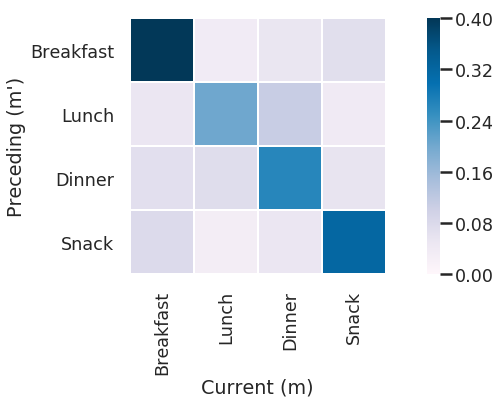

In [6]:
plot_fig5(corr, context="poster")


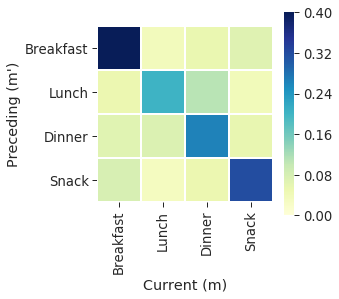

In [7]:
plot_fig5(corr, context="paper")
